In [24]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [1]:
import os, sys
import numpy as np

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
#from mitequinox.binary import *
import mitequinox.parcels as pa
from xmitgcm import llcreader
from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4483532.datarmor0/parcels-502090/libparcels_random_516ad4ee-5e33-4db0-bb6d-6bf49ff3e03b.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=1, cores=1)
w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.73:55252 Dashboard: http://10.148.0.73:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
client

Client Scheduler: tcp://10.148.0.73:55252 Dashboard: http://10.148.0.73:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
import pyinterp

mesh = pyinterp.RTree()

In [5]:
V = ["Eta", "SSU", "SSV", "SST", "SSS"]
D = ["mean"]#, "mean_square"]
ds = xr.merge([load_diagnostic(d+"_"+v).rename({v:d+"_"+v}) 
               for v in V for d in D])

In [6]:
grd = load_grd(V=['XC','YC','CS','SN'])
ds = xr.merge([grd,ds])

In [7]:
#ds = ds.isel(i = slice(0,None,4), j = slice(0,None,4), i_g = slice(0,None,4), j_g = slice(0,None,4))
#ds['lon'] = 0*ds.face+ds.XC
#ds['lat'] = 0*ds.face+ds.YC
ds.load()
#ds = ds.persist()

<xarray.Dataset>
Dimensions:   (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
    XC        (face, j, i) float32 -114.93228 -114.93217 ... -114.932396
    YC        (face, j, i) float32 -88.17715 -88.18007 ... -88.17422 -88.174225
    CS        (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SN        (face, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
  * face      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j         (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    mean_Eta  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSU  (face, j, i_g) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSV  (face, j_g, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SST  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan
    mean_SSS  (face, j, i) float32 nan nan nan nan nan ... nan nan nan nan nan

In [8]:
sli = slice(0,None,1)

In [9]:
U_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.CS - ds.mean_SSV.rename({'j_g': 'j'})*ds.SN
V_mean =  ds.mean_SSU.rename({'i_g': 'i'})*ds.SN + ds.mean_SSV.rename({'j_g': 'j'})*ds.CS

In [10]:
U_mean['lon'] = 0*ds.face+ds.XC
U_mean['lat'] = 0*ds.face+ds.YC

V_mean['lon'] = 0*ds.face+ds.XC
V_mean['lat'] = 0*ds.face+ds.YC

In [11]:
# Mean Eulerian field

ds_mean = xr.Dataset({'meridional_velocity_mean':V_mean,'zonal_velocity_mean':U_mean,
                      'sea_level_mean':ds.mean_Eta,'temperature_mean':ds.mean_SST,'salinity_mean':ds.mean_SSS})

In [12]:
ds_mean

<xarray.Dataset>
Dimensions:                   (face: 13, i: 4320, j: 4320)
Coordinates:
  * j                         (j) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
  * face                      (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i                         (i) int64 0 1 2 3 4 5 ... 4315 4316 4317 4318 4319
    XC                        (face, j, i) float32 -114.93228 ... -114.932396
    YC                        (face, j, i) float32 -88.17715 ... -88.174225
    CS                        (face, j, i) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    SN                        (face, j, i) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lon                       (face, j, i) float64 -114.9 -114.9 ... -114.9
    lat                       (face, j, i) float64 -88.18 -88.18 ... -88.17
Data variables:
    meridional_velocity_mean  (face, j, i) float32 nan nan nan ... nan nan nan
    zonal_velocity_mean       (face, j, i) float32 nan nan nan ... nan nan nan
    sea_level_mean            (face, j, i) float32 nan nan nan ... nan nan nan
    temperature_mean          (face, j, i) float32 nan nan nan ... nan nan nan
    salinity_mean             (face, j, i) float32 nan nan nan ... nan nan nan

In [32]:
mesh.packing(
    np.vstack((V_mean.lon.isel(i=sli,j=sli).values.flatten(), V_mean.lat.isel(i=sli,j=sli).values.flatten())).T,
    V_mean.isel(i=sli,j=sli).values.flatten())

In [35]:
x0, x1 = -180, 180
y0, y1 = -90, 90
#x0,x1 = np.around(ds.lon.isel(face=1).values.min()),np.around(ds.lon.isel(face=1).values.max())
#y0,y1 = np.around(ds.lat.isel(face=1).values.min()),np.around(ds.lat.isel(face=1).values.max())
res = 1 / 32.0
mx, my = np.meshgrid(np.arange(x0, x1, res),
                        np.arange(y0, y1, res),
                        indexing="ij")

#mx, my = np.meshgrid(np.array([0]),
#                     np.array([-40]),
#                       indexing="ij")

In [40]:
idw_eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    radius=None,  # In a radius of 5.5 Km
    k=8,  # We are looking for at most 8 neighbours
    num_threads=1)

In [41]:
idw_eta

array([       nan,        nan,        nan, ..., 0.03661389, 0.03792887,
       0.03915819])

In [21]:
idw_eta, neighbors = mesh.inverse_distance_weighting(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    radius=55000,  # In a radius of 5.5 Km
    k=8,  # We are looking for at most 8 neighbours
    num_threads=0)
idw_eta = idw_eta.reshape(mx.shape)

In [15]:
rbf_eta, neighbors = mesh.radial_basis_function(
    np.vstack((mx.flatten(), my.flatten())).T,
    within=True,  # Extrapolation is forbidden
    k=11,  # We are looking for at most 11 neighbours
    num_threads=0)
rbf_eta = rbf_eta.reshape(mx.shape)

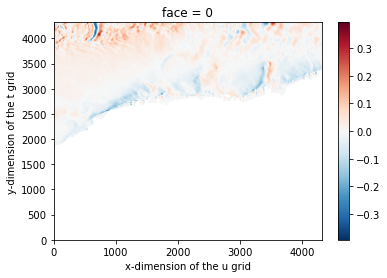

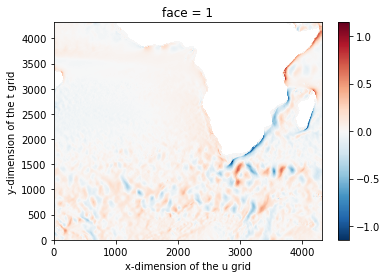

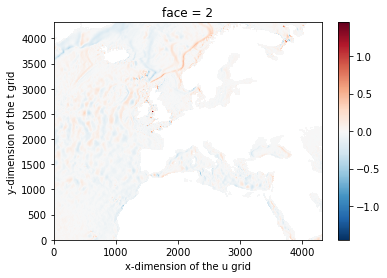

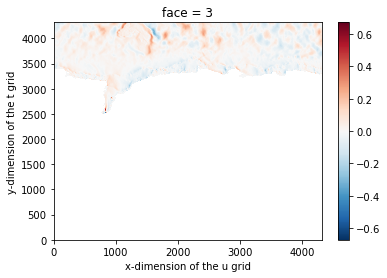

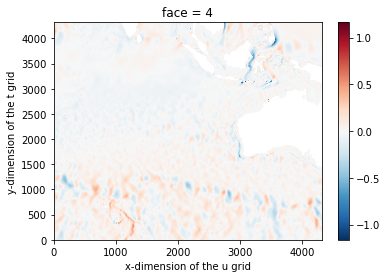

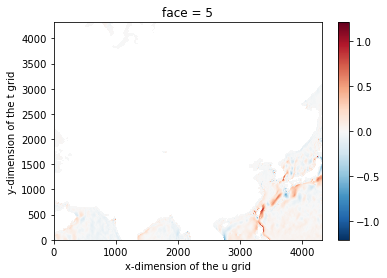

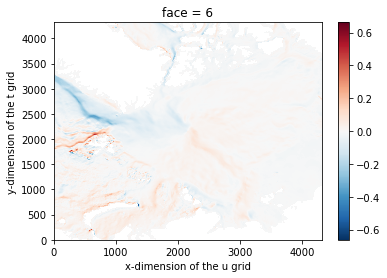

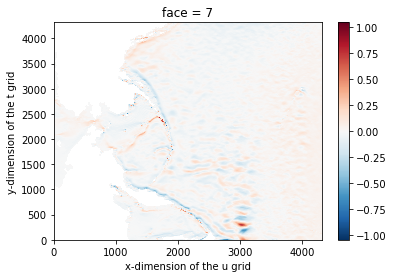

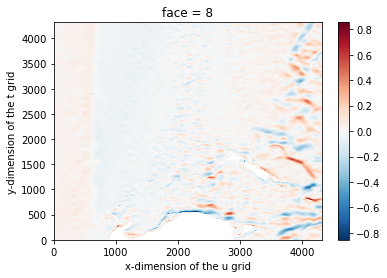

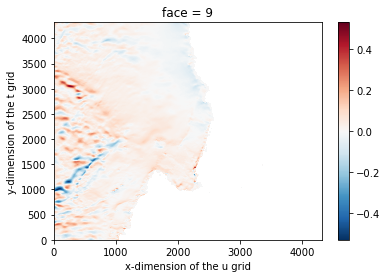

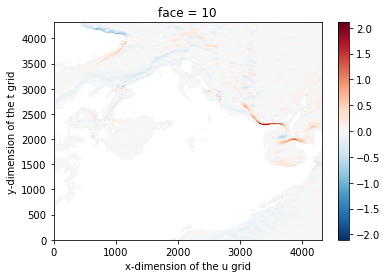

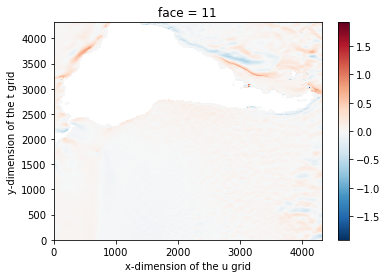

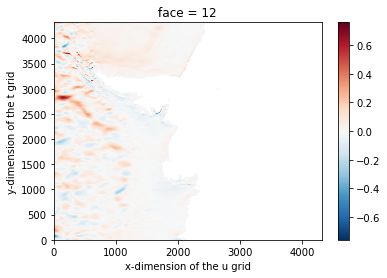

In [17]:
for i in range(V_mean.shape[0]):
    plt.figure()
    V_mean.isel(face=i).plot()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/mitequinox/plot.py:146: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  data_ax = data_ax.transpose()


(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaea4ca0d0>,
       dtype=object))

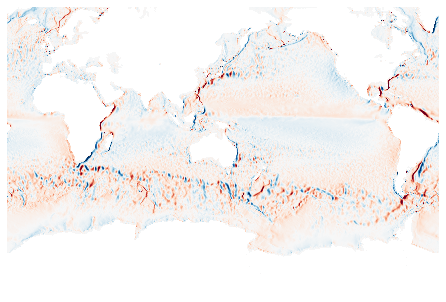

In [18]:
from mitequinox.plot import *
quick_llc_plot(V_mean, vmin=-0.5, vmax=0.5, 
               add_colorbar=False, axis_off=True,cmap='RdBu_r')
#plt.figure()
#plt.pcolormesh(mx,my,idw_eta)
#lt.figure()
#lt.pcolormesh(mx,my,rbf_eta)

(<Figure size 432x288 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaaea85e450>,
       dtype=object))

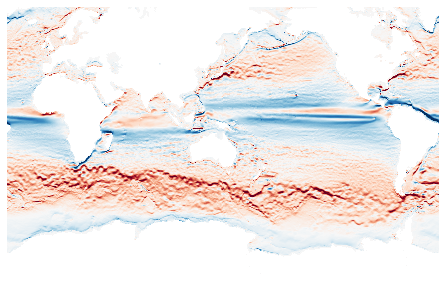

In [19]:
quick_llc_plot(U_mean, vmin=-0.5, vmax=0.5, 
               add_colorbar=False, axis_off=True,cmap='RdBu_r')

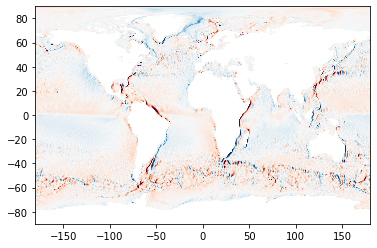

In [14]:
plt.figure()
plt.pcolormesh(mx.T,my.T,idw_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')

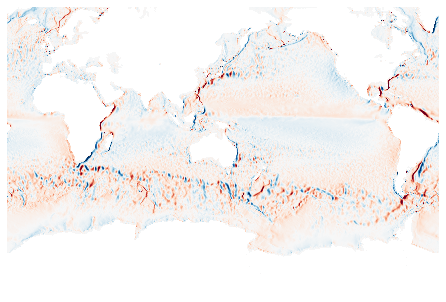

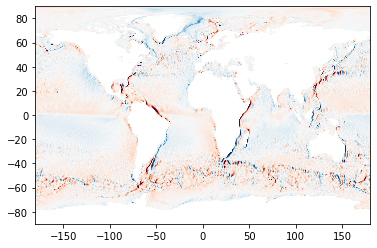

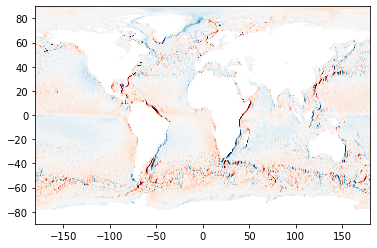

In [33]:
quick_llc_plot(V_mean, vmin=-0.5, vmax=0.5, 
               add_colorbar=False, axis_off=True,cmap='RdBu_r')
plt.figure()
plt.pcolormesh(mx.T,my.T,idw_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')
plt.figure()
plt.pcolormesh(mx.T,my.T,rbf_eta.T, vmin=-0.5, vmax=0.5,cmap='RdBu_r')

### Load Lagrangian data

In [12]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#df = pa.degs2ms(df)
#df = df.repartition(npartitions=60)
df = df.persist()

In [15]:
df_part = df.get_partition(0).persist()

In [16]:
def stacks(df):
    return np.vstack((df.lon[:],df.lat)).T

def mesh_df(d,radius,k):
    
    tst,tst_n = mesh.inverse_distance_weighting(d,
            within=True,  # Extrapolation is forbidden
            radius=radius,  # In a radius of 5.5 Km
            k=k,  # We are looking for at most 8 neighbours
            num_threads=0)
    return tst

def new_dim(df,V,interp):
    df[V+'_interp'] = interp
    return df

In [17]:
stacked = df_part.map_partitions(stacks).compute()

In [18]:
mesh.packing(np.vstack((ds_mean.meridional_velocity_mean.lon.values.flatten(), ds_mean.meridional_velocity_mean.lat.values.flatten())).T,
                 ds_mean.meridional_velocity_mean.values.flatten())


In [ ]:
import dask
meta = {'trajectory': 'int32', 'lat': 'float64', 'lon': 'float64', 'z': 'float64', 'zonal_velocity': 'float64', 'meridional_velocity': 'float64', 'sea_level': 'float64',
        'temperature': 'float32', 'salinity': 'float32'}
var_list = df_part.columns[7:]
#t = []
#for V in var_list:
#    meta.update({V+'_interp':'float32'})
    #d = dask.delayed(mesh_df)(ds_mean[V+'_mean'],stacked,None,4)
    #t.append(d)
t = mesh_df(stacked,None,4)
    #df_interp = df_part.map_partitions(new_dim,V,t,meta=meta).persist()
#result = dask.compute(*t)

In [21]:
result = dask.compute(*t)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py:3339: UserWarning: Large object of size 8.93 GB detected in task graph: 
  (<xarray.DataArray 'temperature_mean' (face: 13, j ... 35]]), None, 4)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


KeyboardInterrupt: 

In [17]:
mesh.packing(np.vstack((V_mean.lon.values.flatten(), V_mean.lat.values.flatten())).T,
                 V_mean.values.flatten())

In [17]:
df_part = df.get_partition(0).persist()
for i in range(1,df.npartitions):
    df_part1 = df.get_partition(i).persist()
    df_part = df_part.append(df_part1)

In [19]:
df_part.lon.values.compute()

array([-178.86708069, -178.87199402, -178.87962341, ...,  -33.16372284,
        -32.54365505,  -34.24717097])

In [24]:
#df_part = df_part1.append(df_part2)
df_part1 = df.get_partition(1).persist()

In [19]:
def mesh_idw(d,radius,k):
   # df_bis = df_sub.copy()
    
    tst,tst_n = mesh.inverse_distance_weighting(d,
            within=True,  # Extrapolation is forbidden
            radius=radius,  # In a radius of 5.5 Km
            k=k,  # We are looking for at most k neighbours
            num_threads=0)
    #if tst[np.isnan(tst)==True].size != tst.size:
    #    df_bis['interp'] = tst
    #else:
    #    print('No')
    return [tst,tst_n] # df_bis
def test(d,k):
    return d+k

In [20]:
import dask

mesh_idw = dask.delayed(mesh_idw)

In [20]:
#t = dask.delayed(mesh_idw)(stacked,None,4)
#t = dask.delayed(test)(stacked,4)
t = mesh_idw(stacked,None,8)

In [26]:
stacked.shape[0]

10648534

In [31]:
import dask.array as da
test = da.from_delayed(t[0],(stacked.shape[0],),dtype='float64')

In [32]:
test.compute()

array([nan, nan, nan, ..., nan, nan, nan])

In [49]:
T = []
for var in ['zonal_velocity','meridional_velocity']:
    mesh.packing(np.vstack((ds_mean[var+'_mean'].lon.values.flatten(), ds_mean[var+'_mean'].lat.values.flatten())).T,
                  ds_mean[var+'_mean'].values.flatten())
    t = mesh_idw(stacked,None,8)
    T.append(t)
    

In [ ]:
T = dask.compute(*T)

In [34]:
dask.delayed?

Signature:      
dask.delayed(
    obj='__no__default__',
    name=None,
    pure=None,
    nout=None,
    traverse=True,
)
Call signature:  dask.delayed(*args, **kwargs)
Type:            curry
String form:     <function delayed at 0x2aaad5a53ef0>
File:            ~/miniconda3/envs/croco/lib/python3.7/site-packages/cytoolz/functoolz.cpython-37m-x86_64-linux-gnu.so
Docstring:      
Wraps a function or object to produce a ``Delayed``.

``Delayed`` objects act as proxies for the object they wrap, but all
operations on them are done lazily by building up a dask graph internally.

Parameters
----------
obj : object
    The function or object to wrap
name : string or hashable, optional
    The key to use in the underlying graph for the wrapped object. Defaults
    to hashing content. Note that this only affects the name of the object
    wrapped by this call to delayed, and *not* the output of delayed
    function calls - for that use ``dask_key_name=`` as described below.
pure : bool, optio

In [21]:
meta={'trajectory': 'int32', 'lat': 'float64', 'lon': 'float64', 'z': 'float64', 'zonal_velocity': 'float64', 'meridional_velocity': 'float64', 'sea_level': 'float64',
                                       'temperature': 'float32', 'salinity': 'float32','meridional_velocity_interp':'float64'}

In [22]:
df_interp = df_part.map_partitions(new_dim,'meridional_velocity',t,meta=meta).persist()

In [67]:
df_interp.meridional_velocity_interp.compute()

time
2011-11-15 00:00:00   -0.006017
2011-11-15 00:00:00    0.050204
2011-11-15 00:00:00    0.209887
2011-11-15 00:00:00    0.064889
2011-11-15 00:00:00    0.057710
                         ...   
2012-07-04 08:00:00   -0.015104
2012-07-04 08:00:00    0.021951
2012-07-04 08:00:00    0.049233
2012-07-04 08:00:00   -0.033297
2012-07-04 08:00:00   -0.052849
Name: meridional_velocity_interp, Length: 3188863, dtype: float64

In [25]:
for i in range(15,30):
    df_part = df.get_partition(i).persist()
    stacked = df_part.map_partitions(stacks).compute()
    t = mesh_idw(stacked,None,4)#dask.delayed(mesh_idw)(stacked,None,4)
    interp_part = df_part.map_partitions(new_dim,'meridional_velocity',t,meta=meta).persist()
    df_interp = df_interp.append(interp_part)

In [30]:
ds, dirs = pa.load_logs(root_dir, run_name)
pa.store_parquet(dirs["parquets"], df_interp, overwrite=True, name="interp_mean")

No reindexing
create new archive: /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets/interp_mean


KeyboardInterrupt: 

In [33]:
df_interp_test = df_interp.get_partition(10).compute()
#df_interp.sea_level_interp.compute()

ValueError: Inputs contain futures that were created by another client.

In [63]:
for i in np.arange(4,10):
    df_part = df.get_partition(i).persist()
    stacked = df_part.map_partitions(stacks).compute()
    t = mesh_idw(stacked,None,4)
    t_part = df_part.map_partitions(new_dim,'meridional_velocity',t,meta={'trajectory': 'int32', 'lat': 'float64', 'lon': 'float64', 'z': 'float64', 'zonal_velocity': 'float64', 'meridional_velocity': 'float64', 'sea_level': 'float64',
                                       'temperature': 'float32', 'salinity': 'float32'}).persist()
    T = T.append(t_part)

In [69]:
test_out = T.get_partition(0).persist()

In [70]:
test_out.meridional_velocity.compute()

time
2012-05-14 00:00:00    0.125273
2012-05-14 00:00:00    0.110353
2012-05-14 00:00:00   -0.166636
2012-05-14 00:00:00   -0.066352
2012-05-14 00:00:00    0.034306
                         ...   
2012-10-06 01:00:00   -0.064824
2012-10-06 01:00:00   -0.002482
2012-10-06 01:00:00    0.012875
2012-10-06 01:00:00    0.026706
2012-10-06 01:00:00   -0.023128
Name: meridional_velocity, Length: 12114518, dtype: float64

In [ ]:
def interp_trajectories(df_sub,columnsds_mean,radius,k,method):
        mesh.packing(
        np.vstack((ds_mean.lon.values.flatten(), ds_mean.lat.values.flatten())).T,
        ds_mean.values.flatten())
        #mx, my = np.meshgrid(df_sub.lon,
        #                    df_sub.lat,
        #                    indexing="ij")
        if method=='idw':
            idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
            within=True,  # Extrapolation is forbidden
            radius=radius,  # In a radius of 5.5 Km
            k=k,  # We are looking for at most 8 neighbours
            num_threads=0)
            interp_var = idw_eta#.reshape((df_sub.lon.size,df_sub.lat.size))
        if method=='rbf':
            rbf_eta, neighbors = mesh.radial_basis_function(
            np.vstack((mx.flatten(), my.flatten())).T,
            within=True,  # Extrapolation is forbidden
            k=k,  # We are looking for at most 11 neighbours
            num_threads=1)
            interp_var = rbf_eta#.reshape((df_sub.lon.size,df_sub.lat.size))
        df_sub[V+'_interp'] = interp_var#pd.Series(index=df.index,np.diag(interp_var))
    #df = df.drop(['z','sea_level','salinity','temperature'])
        #DF[V+'_mean'] = np.diag(interp_var)
    return  df_sub#pd.Series(data=np.diag(interp_var))

In [22]:
def interp_trajectories(df_sub,columns,radius,k,method):
    #df_interp = df.copy()
    #DF = pd.DataFrame(data={'lon':df.lon,'lat':df.lat},index=df.index)
    for i,V in enumerate(columns):
        #mesh.packing(
        #np.vstack((ds.lon.isel(face=1).values.flatten(), ds.lat.isel(face=1).values.flatten())).T,
        #ds[var_mean[i]].isel(face=1).values.flatten())
        
        #mx, my = np.meshgrid(df_sub.lon,
        #                    df_sub.lat,
        #                    indexing="ij")
        if method=='idw':
            idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
            within=True,  # Extrapolation is forbidden
            radius=radius,  # In a radius of 5.5 Km
            k=k,  # We are looking for at most 8 neighbours
            num_threads=0)
            interp_var = idw_eta#.reshape((df_sub.lon.size,df_sub.lat.size))
        if method=='rbf':
            rbf_eta, neighbors = mesh.radial_basis_function(
            np.vstack((mx.flatten(), my.flatten())).T,
            within=True,  # Extrapolation is forbidden
            k=k,  # We are looking for at most 11 neighbours
            num_threads=1)
            interp_var = rbf_eta#.reshape((df_sub.lon.size,df_sub.lat.size))
        df_sub[V+'_interp'] = interp_var#pd.Series(index=df.index,np.diag(interp_var))
        #df_sub[V] = interp_var#pd.Series(index=df.index,np.diag(interp_var))
        #df_sub = df_sub.drop([V])
    #df_sub = df_sub.drop(['z','sea_level','salinity','temperature'])
        #DF[V+'_mean'] = np.diag(interp_var)
    return  df_sub#pd.Series(data=np.diag(interp_var))

### Test interpolation one trajectory : 

In [18]:
df_tst = df.groupby('trajectory').get_group(4000125).compute()


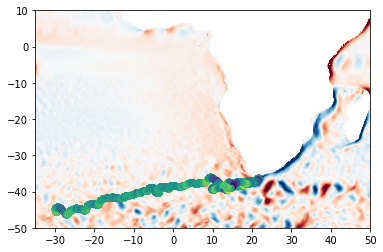

In [42]:
plt.pcolormesh(V_mean.lon.isel(face=1),V_mean.lat.isel(face=1),V_mean.isel(face=1),cmap='RdBu_r',vmin=-0.5,vmax=0.5)
#from mitequinox.plot import *

#quick_llc_plot(V_mean, vmin=-0.5, vmax=0.5, 
#               add_colorbar=False, axis_off=False
#               ,cmap='RdBu_r')
plt.ylim(-50,10);plt.xlim(-35,50)
plt.scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity)

In [21]:
tst_idw = interp_trajectories(df_tst,['zonal_velocity','meridional_velocity'],[U_mean,V_mean],None,8,'idw')
#tst_rbf = interp_trajectories(df_tst,['zonal_velocity','meridional_velocity'],['mean_SSU','mean_SSV'],None,8,'rbf')

In [22]:
tst_idw


,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15 00:00:00,4000125,-45.811852,-29.656250,0.0,0.091824,0.103792,0.000000,0.000000,0.000000
2011-11-15 01:00:00,4000125,-45.803757,-29.657835,0.0,0.091647,0.102723,-0.135480,8.108259,34.434158
2011-11-15 02:00:00,4000125,-45.795042,-29.660794,0.0,0.091437,0.102115,-0.155263,8.118768,34.440628
2011-11-15 03:00:00,4000125,-45.786856,-29.664661,0.0,0.090834,0.101291,-0.225573,8.134237,34.446270
2011-11-15 04:00:00,4000125,-45.779900,-29.667672,0.0,0.090298,0.101476,-0.333419,8.064259,34.435791
...,...,...,...,...,...,...,...,...,...
2011-12-02 21:00:00,4000125,-45.998920,-26.537976,0.0,0.048169,0.081050,-0.532316,8.472935,34.373360
2011-12-02 22:00:00,4000125,-45.988686,-26.532935,0.0,0.046413,0.080304,-0.595680,8.489898,34.380844
2011-12-02 23:00:00,4000125,-45.979609,-26.525990,0.0,0.045210,0.079594,-0.597909,8.490442,34.385288


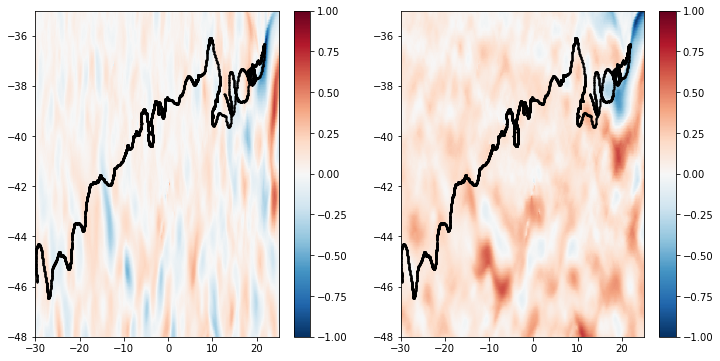

In [43]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].pcolormesh(ds.lon.isel(face=1),ds.lat.isel(face=1),V_mean.isel(face=1),cmap='RdBu_r',vmin=-1,vmax=1)
cs1 = ax[1].pcolormesh(ds.lon.isel(face=1),ds.lat.isel(face=1),U_mean.isel(face=1),cmap='RdBu_r',vmin=-1,vmax=1)
for a in ax:
    a.set_ylim(-48,-35);a.set_xlim(-30,25)
    a.scatter(df_tst.lon,df_tst.lat,s=1,c='k')
plt.colorbar(cs,ax=ax[0])
plt.colorbar(cs1,ax=ax[1])

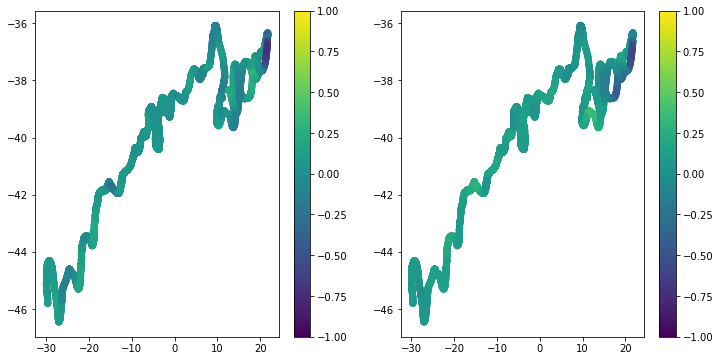

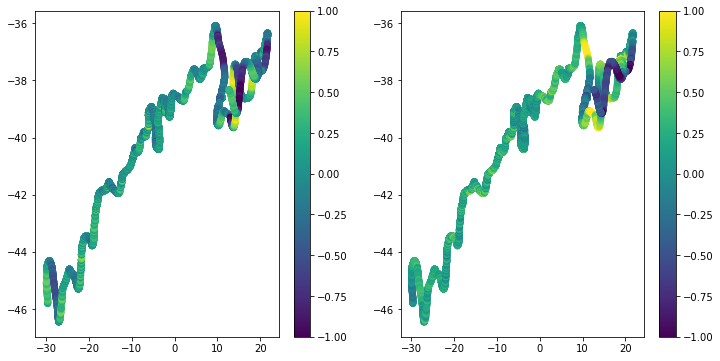

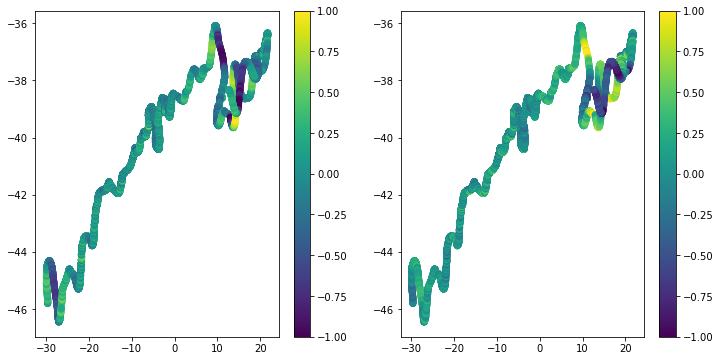

In [44]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(tst_idw.lon,tst_idw.lat,c=tst_idw.meridional_velocity,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=tst_idw.zonal_velocity,vmin=-1,vmax=1)
plt.colorbar(cs,ax=ax[0]);plt.colorbar(cs1,ax=ax[1])
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.zonal_velocity,vmin=-1,vmax=1)
plt.colorbar(cs,ax=ax[0]);plt.colorbar(cs1,ax=ax[1])
fig,ax = plt.subplots(1,2,figsize=(12,6))
cs = ax[0].scatter(df_tst.lon,df_tst.lat,c=df_tst.meridional_velocity-tst_idw.meridional_velocity,vmin=-1,vmax=1)
cs1 = ax[1].scatter(df_tst.lon,df_tst.lat,c=df_tst.zonal_velocity-tst_idw.zonal_velocity,vmin=-1,vmax=1)
plt.colorbar(cs,ax=ax[0]);plt.colorbar(cs1,ax=ax[1])

### Test with several partitions : 

In [14]:
def interp_trajectories(df_sub,columns,radius,k,method):
    for i,V in enumerate(columns):
        if method=='idw':
            idw_eta, neighbors = mesh.inverse_distance_weighting(
            np.vstack((df_sub.lon[:], df_sub.lat[:])).T,
            within=True,  # Extrapolation is forbidden
            radius=radius,  # In a radius of 5.5 Km
            k=k,  # We are looking for at most 8 neighbours
            num_threads=0)
            interp_var = idw_eta#.reshape((df_sub.lon.size,df_sub.lat.size))
        if method=='rbf':
            rbf_eta, neighbors = mesh.radial_basis_function(
            np.vstack((mx.flatten(), my.flatten())).T,
            within=True,  # Extrapolation is forbidden
            k=k,  # We are looking for at most 11 neighbours
            num_threads=0)
            interp_var = rbf_eta#.reshape((df_sub.lon.size,df_sub.lat.size))
        df_sub[V+'_interp'] = interp_var#pd.Series(index=df.index,np.diag(interp_var))
        #df_sub[V] = interp_var#pd.Series(index=df.index,np.diag(interp_var))
        #df_sub = df_sub.drop([V])
    #df_sub = df_sub.drop(['z','sea_level','salinity','temperature'])
        #DF[V+'_mean'] = np.diag(interp_var)
    return  df_sub#pd.Series(data=np.diag(interp_var))

In [15]:
vmean = 'meridional_velocity_mean'

In [16]:
 mesh.packing(np.vstack((ds_mean[vmean].lon.values.flatten(), ds_mean[vmean].lat.values.flatten())).T,ds_mean[vmean].values.flatten())

In [18]:
df_part = df.get_partition(0).persist()
df_part1 = df.get_partition(1).persist()

In [19]:
df_part = df_part.append(df_part1)

In [36]:
meta={'trajectory': 'int32', 'lat': 'float64', 'lon': 'float64', 'z': 'float64', 'zonal_velocity': 'float64', 'meridional_velocity': 'float64', 'sea_level': 'float64',
                                       'temperature': 'float32', 'salinity': 'float32','meridional_velocity_interp':'float64'}

In [37]:
tst_idw = df_part.map_partitions(interp_trajectories,['meridional_velocity'],None,8,'idw',meta=meta)
#tst_idw = interp_trajectories(df_part,['meridional_velocity'],[V_mean],None,8,'idw')

In [38]:
tst_idw

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,meridional_velocity_interp
npartitions=2,,,,,,,,,,
,int32,float64,float64,float64,float64,float64,float64,float32,float32,float64
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [24]:
df_test = tst_idw.get_partition(0).compute()
#tst_idw.meridional_velocity_interp.compute()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/worker.py:3339: UserWarning: Large object of size 8.73 GB detected in task graph: 
  ("('get-partition-0-read-parquet-4c421fe2122548150 ... bf58b362', 0)")
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [28]:
df_test1 = tst_idw.get_partition(1).compute()

In [29]:
df_test1.meridional_velocity_interp

time
2012-04-01 00:00:00   -0.024458
2012-04-01 00:00:00    0.022591
2012-04-01 00:00:00   -0.049825
2012-04-01 00:00:00    0.017048
2012-04-01 00:00:00    0.011294
                         ...   
2012-07-27 01:00:00   -0.021877
2012-07-27 01:00:00    0.042093
2012-07-27 01:00:00   -0.013796
2012-07-27 01:00:00    0.084917
2012-07-27 01:00:00         NaN
Name: meridional_velocity_interp, Length: 1779518, dtype: float64

### Whole dataset

In [19]:
meta={'trajectory': 'int32', 'lat': 'float64', 'lon': 'float64', 'z': 'float64', 'zonal_velocity': 'float64', 'meridional_velocity': 'float64', 'sea_level': 'float64',
                                       'temperature': 'float32', 'salinity': 'float32','meridional_velocity_interp':'float64'}

In [20]:
df_interp = df.map_partitions(interp_trajectories,['meridional_velocity'],None,8,'idw',meta=meta)

In [21]:
df_interp

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,meridional_velocity_interp
npartitions=377,,,,,,,,,,
,int32,float64,float64,float64,float64,float64,float64,float32,float32,float64
,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [22]:
df_test = df_interp.get_partition(0).compute()

In [23]:
df_test

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,meridional_velocity_interp
time,,,,,,,,,,
2011-11-15 00:00:00,39000000,57.835732,-178.867081,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
2011-11-15 00:00:00,39000001,58.429878,-178.871994,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
2011-11-15 00:00:00,39000002,59.018066,-178.879623,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
2011-11-15 00:00:00,39000003,59.600288,-178.890015,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
2011-11-15 00:00:00,39000004,60.176525,-178.903275,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
2012-04-01 01:00:00,39000883,59.469786,-164.988236,0.0,-1.285918e-05,-1.987215e-06,1.059005,-1.706309,31.267990,NaN
2012-04-01 01:00:00,39000886,71.243197,-155.821933,0.0,9.731632e-08,-3.858862e-08,-3.369833,-1.802421,32.913410,NaN
2012-04-01 01:00:00,39000887,57.695752,-158.033037,0.0,1.068998e-05,6.569532e-06,3.122235,-1.724739,31.615957,NaN


In [21]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
